<a href="https://colab.research.google.com/github/drfperez/openair/blob/main/WASP39b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

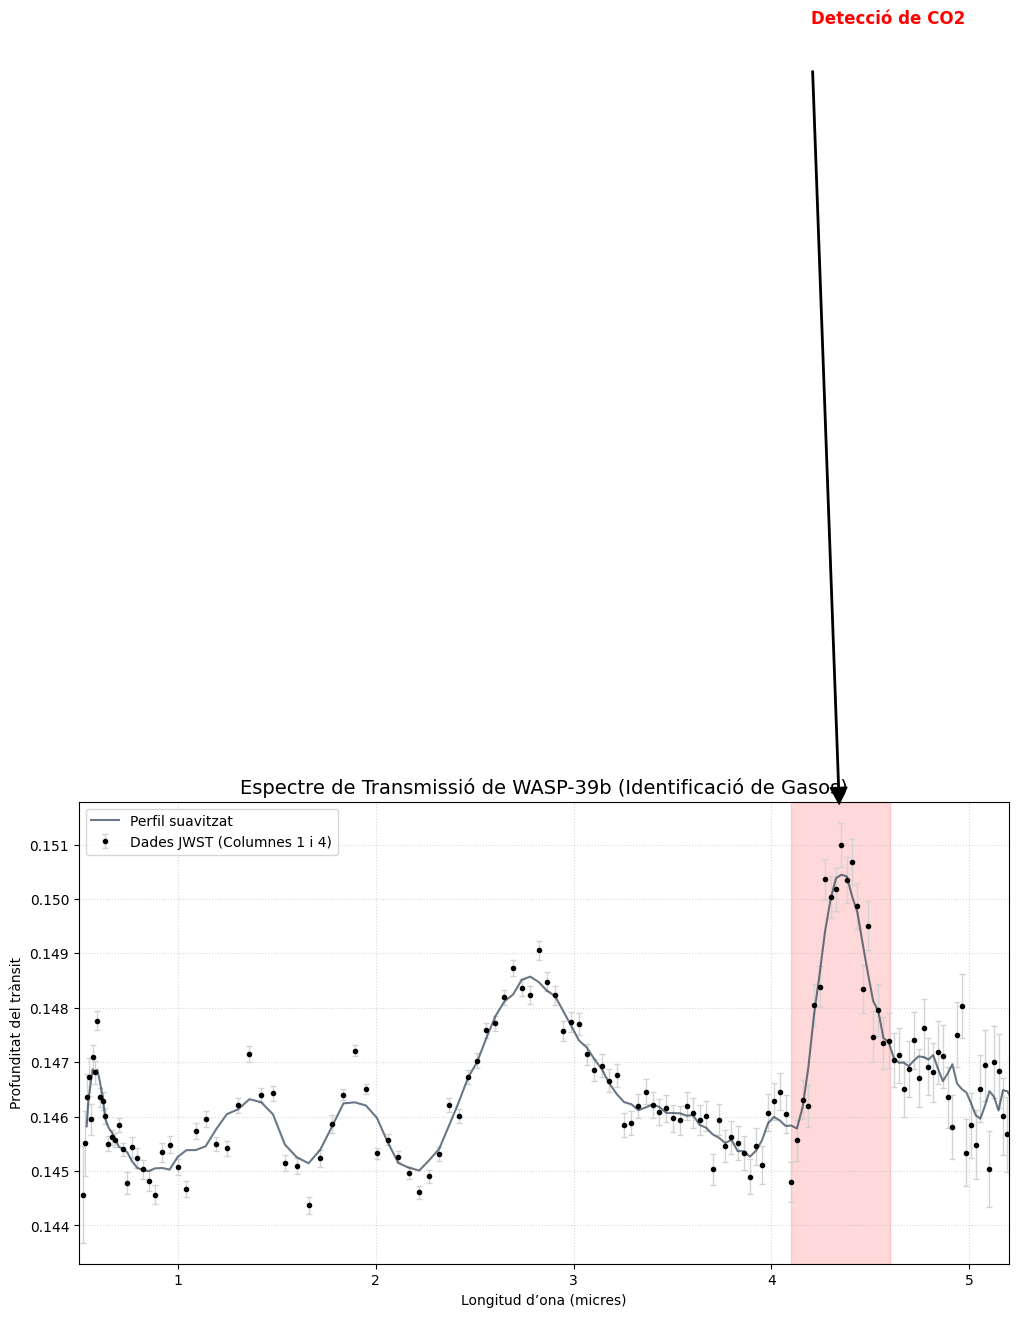

In [24]:

import pandas as pd
import matplotlib.pyplot as plt

# Ruta del fitxer confirmat
fitxer = 'wasp39b_data/ZENODO/4_TRANSMISSION_SPECTRA/Fixed_LimbDarkening/NIRSpec_PRISM/bins_scale1.csv'

# Carreguem el fitxer
df = pd.read_csv(fitxer, header=None)

# Segons l'estàndard d'aquests fitxers de la NASA/Zenodo:
# Columna 1: Longitud d'ona (Wavelength)
# Columna 4: Profunditat del trànsit (Transit Depth) <- AQUESTA ÉS LA BONA
# Columna 5: Error
wl = pd.to_numeric(df[1], errors='coerce')
depth = pd.to_numeric(df[4], errors='coerce')
error = pd.to_numeric(df[5], errors='coerce')

# Netegem files buides
mask = wl.notna() & depth.notna()
wl, depth, error = wl[mask], depth[mask], error[mask]

# Gràfic de precisió
plt.figure(figsize=(12, 6))

# Dades amb barres d'error
plt.errorbar(wl, depth, yerr=error, fmt='o', markersize=3,
             color='black', ecolor='lightgray', elinewidth=1, capsize=2, label='Dades JWST (Columnes 1 i 4)')

# Tendència per identificar els pics
plt.plot(wl, depth.rolling(window=5, center=True).mean(), color='#2c3e50', alpha=0.7, label='Perfil suavitzat')

# EL PIC DE CO2 (4.3 μm)
plt.axvspan(4.1, 4.6, color='red', alpha=0.15)
plt.annotate('Detecció de CO2', xy=(4.35, depth.loc[(wl-4.35).abs().idxmin()]),
             xytext=(4.2, depth.max()*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontsize=12, fontweight='bold', color='red')

plt.title('Espectre de Transmissió de WASP-39b (Identificació de Gasos)', fontsize=14)
plt.xlabel('Longitud d’ona (micres)')
plt.ylabel('Profunditat del trànsit')
plt.xlim(0.5, 5.2)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend()
plt.show()

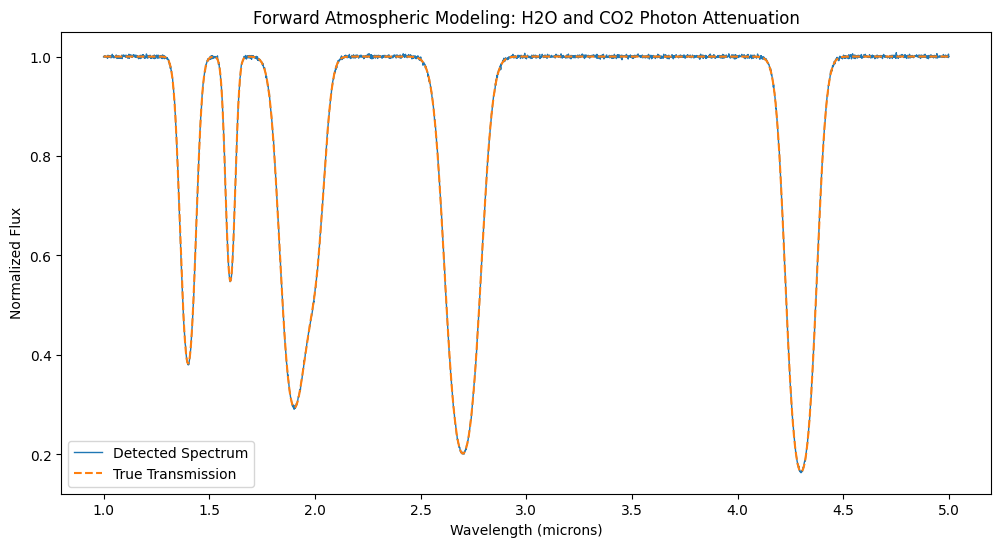

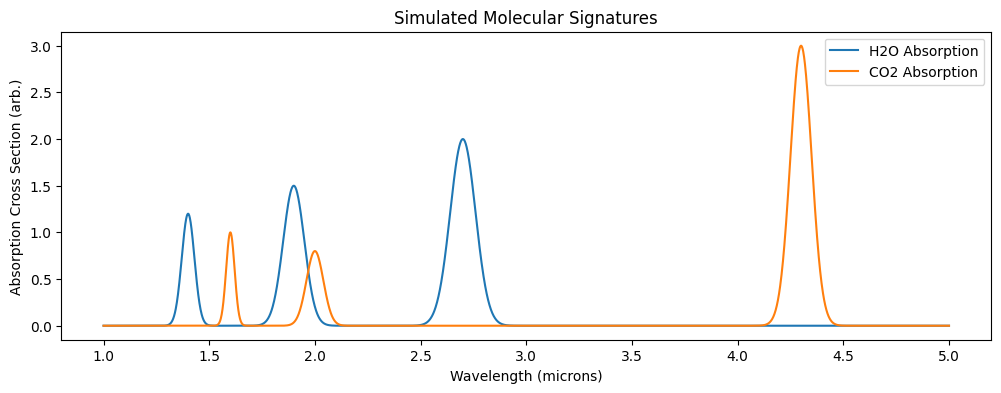

In [ ]:
# ==========================================
# Simple Forward Atmospheric Modeling Demo
# Photon attenuation + H2O and CO2 features
# ==========================================

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. Wavelength grid (microns)
# ---------------------------
wavelength = np.linspace(1.0, 5.0, 3000)

# ---------------------------
# 2. Helper: Gaussian line
# ---------------------------
def gaussian_line(wl, center, width, strength):
    return strength * np.exp(-0.5*((wl-center)/width)**2)

# ---------------------------
# 3. Approx absorption spectra
# (toy molecular signatures)
# ---------------------------

# H2O prominent bands ~1.4, 1.9, 2.7 micron
sigma_H2O = (
    gaussian_line(wavelength, 1.4, 0.03, 1.2) +
    gaussian_line(wavelength, 1.9, 0.05, 1.5) +
    gaussian_line(wavelength, 2.7, 0.06, 2.0)
)

# CO2 prominent bands ~1.6, 2.0, 4.3 micron
sigma_CO2 = (
    gaussian_line(wavelength, 1.6, 0.02, 1.0) +
    gaussian_line(wavelength, 2.0, 0.04, 0.8) +
    gaussian_line(wavelength, 4.3, 0.05, 3.0)
)

# ---------------------------
# 4. Atmospheric parameters
# ---------------------------
n_H2O = 0.8     # relative abundance
n_CO2 = 0.6
path_length = 1.0

# Optical depth
tau = path_length * (n_H2O*sigma_H2O + n_CO2*sigma_CO2)

# ---------------------------
# 5. Stellar input spectrum
# ---------------------------
I0 = np.ones_like(wavelength)

# Transmission
transmission = np.exp(-tau)

# Observed flux
observed_flux = I0 * transmission

# Add high-precision detector noise
noise_level = 0.002
noise = np.random.normal(0, noise_level, size=len(wavelength))
detected_flux = observed_flux + noise

# ---------------------------
# 6. Plot results
# ---------------------------
plt.figure(figsize=(12,6))
plt.plot(wavelength, detected_flux, label="Detected Spectrum", linewidth=1)
plt.plot(wavelength, observed_flux, linestyle='--', label="True Transmission")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Normalized Flux")
plt.title("Forward Atmospheric Modeling: H2O and CO2 Photon Attenuation")
plt.legend()
plt.show()

# ---------------------------
# 7. Plot molecular signatures
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(wavelength, sigma_H2O, label="H2O Absorption")
plt.plot(wavelength, sigma_CO2, label="CO2 Absorption")
plt.xlabel("Wavelength (microns)")
plt.ylabel("Absorption Cross Section (arb.)")
plt.title("Simulated Molecular Signatures")
plt.legend()
plt.show()

In [ ]:

# Aquest codi és un script per a Google Colab que descarrega dades espectrals de WASP-39b des de Zenodo,
# les descomprimeix, llista tots els fitxers extrets per depuració, cerca un fitxer específic d'espectre de transmissió combinat,
# carrega les dades amb pandas i crea un gràfic de l'espectre de transmissió utilitzant matplotlib.
# Si no es troba el fitxer, llista fitxers potencials que contenen 'spectrum' o 'transmission' per ajudar a identificar-lo.
# El codi està dissenyat per executar-se en una única cel·la de Colab.

# Primer, descarreguem l'arxiu ZIP de dades des de Zenodo utilitzant wget.
# L'URL apunta al fitxer ZIP que conté les dades de síntesi ERS per WASP-39b.
# El guardem com a 'data.zip' al directori temporal de Colab.
!wget "https://zenodo.org/records/10161743/files/ERS_DataSynthesis_Zenodo.zip?download=1" -O data.zip

# Descomprimim l'arxiu ZIP en silenci (-q) a un directori anomenat 'wasp39b_data'.
# Això extreu tots els fitxers i subdirectoris continguts en el ZIP.
!unzip -q data.zip -d wasp39b_data

# Importem les llibreries necessàries:
# - os: per navegar pel sistema de fitxers i trobar fitxers.
# - pandas (pd): per carregar i manipular dades tabulars com CSV o fitxers de text.
# - matplotlib.pyplot (plt): per crear gràfics i visualitzacions.
import os
import pandas as pd
import matplotlib.pyplot as plt

# Llista tots els fitxers extrets per depuració, per veure què hi ha al directori.
print("Llista de tots els fitxers extrets a 'wasp39b_data':")
all_files = []
for root, dirs, files in os.walk('wasp39b_data'):
    for file in files:
        file_path = os.path.join(root, file)
        all_files.append(file_path)
        print(file_path)
print(f"Total de fitxers: {len(all_files)}")

# Ara, busquem el fitxer de l'espectre de transmissió combinat dins del directori extret.
# Utilitzem os.walk per recórrer tots els subdirectoris i fitxers.
# Criteris de cerca: ampliem per incloure fitxers amb 'transmission' o 'spectrum' en el nom, i 'combined' o 'benchmark' o 'wasp39b',
# i ha d'acabar en .csv, .txt, .dat (formats comuns per dades espectrals).
# Això és més flexible per trobar el fitxer correcte.
spectrum_file = None
potential_files = []
for root, dirs, files in os.walk('wasp39b_data'):
    for file in files:
        lower_file = file.lower()
        if ('transmission' in lower_file or 'spectrum' in lower_file) and (lower_file.endswith('.csv') or lower_file.endswith('.txt') or lower_file.endswith('.dat')):
            potential_files.append(os.path.join(root, file))
            if ('combined' in lower_file or 'benchmark' in lower_file or 'wasp39b' in lower_file):
                spectrum_file = os.path.join(root, file)
                break
    if spectrum_file:
        break

# Si no hem trobat un fitxer exacte, mostrem els fitxers potencials perquè l'usuari pugui triar i ajustar manualment.
if not spectrum_file:
    print("\nNo s'ha trobat un fitxer d'espectre de transmissió combinat amb els criteris estrictes.")
    if potential_files:
        print("Fitxers potencials que contenen 'transmission' o 'spectrum' en el nom:")
        for p_file in potential_files:
            print(p_file)
        # Pots assignar manualment un fitxer aquí, per exemple:
        # spectrum_file = potential_files[0]  # Triar el primer, o especifica el camí.
    else:
        print("No hi ha fitxers amb 'transmission' o 'spectrum' en el nom. Comprova la llista completa d'arxius.")

# Si hem trobat (o assignat) el fitxer, procedim a l'anàlisi.
if spectrum_file:
    print(f"\nFitxer d'espectre trobat: {spectrum_file}")
    # Carreguem les dades amb pandas.
    # Assumim un format de fitxer delimitat per espais blancs o comes, amb possibles comentaris (#).
    # Les columnes típiques són: wavelength (longitud d'ona en μm), depth o (Rp/Rs)^2 (profunditat de trànsit), error (incertesa).
    # Si el format no coincideix, ajusta les columnes manualment (names=['wavelength', 'depth', 'error']).
    # Pots inspeccionar el fitxer amb pd.read_csv(..., nrows=10) per veure les columnes.
    try:
        df = pd.read_csv(spectrum_file, comment='#', delim_whitespace=True, names=['wavelength', 'depth', 'error'])
    except Exception as e:
        print(f"Error carregant amb noms assumits: {e}")
        try:
            df = pd.read_csv(spectrum_file, comment='#', delim_whitespace=True)
            print("Columnes detectades automàticament:", df.columns)
        except Exception as e2:
            print(f"Error carregant el fitxer: {e2}")
            df = None

    if df is not None:
        # Mostrem una previsualització de les dades per verificar que s'han carregat correctament.
        # Això imprimeix les primeres 5 files del DataFrame.
        print("\nPrevisualització de les dades:")
        print(df.head())

        # Anàlisi bàsica: calcularem estadístiques descriptives de la profunditat de trànsit.
        # Això inclou mitjana, desviació estàndard, mínim, màxim, etc.
        # Assumim que la columna de profunditat és 'depth' o la segona columna.
        depth_col = 'depth' if 'depth' in df.columns else df.columns[1]
        print("\nEstadístiques descriptives de la profunditat de trànsit:")
        print(df[depth_col].describe())

        # Anàlisi addicional: identifiquem possibles característiques d'absorció.
        # Per exemple, cerquem on la profunditat és major que la mitjana + 1 desviació estàndard (possibles pics).
        mean_depth = df[depth_col].mean()
        std_depth = df[depth_col].std()
        absorption_features = df[df[depth_col] > mean_depth + std_depth]
        print("\nPossibles característiques d'absorció (profunditat > mitjana + 1 SD):")
        print(absorption_features)

        # Visualització: traçem l'espectre de transmissió amb barres d'error.
        # Utilitzem un gràfic de punts amb errors (errorbar) per mostrar les dades.
        # Assumim columnes: 'wavelength', depth_col, 'error' si existeix.
        plt.figure(figsize=(10, 6))  # Definim la mida de la figura per millor visibilitat.
        error_col = 'error' if 'error' in df.columns else None
        plt.errorbar(df['wavelength'], df[depth_col], yerr=df[error_col] if error_col else None, fmt='o', label='Espectre de transmissió', color='blue')

        # Afegim una línia horitzontal per la mitjana de profunditat com a referència.
        plt.axhline(y=mean_depth, color='red', linestyle='--', label='Mitjana de profunditat')

        # Etiquetes i títol per fer el gràfic més informatiu.
        plt.xlabel('Longitud d\'ona (μm)')  # Eix X: longitud d'ona en micròmetres.
        plt.ylabel('(Rp/Rs)^2 o profunditat de trànsit')  # Eix Y: ràtio de radi o profunditat.
        plt.title('Espectre de transmissió de WASP-39b (JWST)')  # Títol del gràfic.
        plt.legend()  # Mostrem la llegenda.
        plt.grid(True)  # Afegim una graella per facilitar la lectura.
        plt.show()  # Mostrem el gràfic a Colab.

        # Suggeriments per continuar l'anàlisi:
        # - Ajusta les columnes si no coincideixen (p.ex. df = df.rename(columns={df.columns[0]: 'wavelength', df.columns[1]: 'depth', df.columns[2]: 'error'}))
        # - Per un ajust de model (p.ex. atmosfera amb aigua), pots importar scipy i utilitzar curve_fit.
        # - Per detectar pics, utilitza scipy.signal.find_peaks sobre la columna de profunditat.
        # Exemple: from scipy.signal import find_peaks; peaks, _ = find_peaks(df[depth_col]); print(df.iloc[peaks])
        # - Per anàlisi química, compara amb models teòrics o utilitza paquets com taurex o petitRADTRANS si estan disponibles.
else:
    print("No es pot procedir sense un fitxer d'espectre. Assigna 'spectrum_file' manualment basant-te en la llista.")

--2026-02-10 12:29:33--  https://zenodo.org/records/10161743/files/ERS_DataSynthesis_Zenodo.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.48.75, 137.138.52.235, 188.184.98.114, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1738391871 (1.6G) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.62G  17.4MB/s    in 99s     

2026-02-10 12:31:13 (16.8 MB/s) - ‘data.zip’ saved [1738391871/1738391871]

Llista de tots els fitxers extrets a 'wasp39b_data':
wasp39b_data/__MACOSX/ZENODO/._.DS_Store
wasp39b_data/__MACOSX/ZENODO/2_WHITE_LIGHT_CURVES/._plots.ipynb
wasp39b_data/__MACOSX/ZENODO/2_WHITE_LIGHT_CURVES/._priors-and-posteriors-eccentric
wasp39b_data/__MACOSX/ZENODO/2_WHITE_LIGHT_CURVES/._fit.py
wasp39b_data/__MACOSX/ZENODO/2_WHITE_LIGHT_CURVES/priors-and-posteriors-eccentric/._lc.dat
wasp39b_data/__MACOSX/ZENODO/2_WHITE_LIGHT_CURVES/priors-and-p